# L1 norm prior experiment

This code attempts to learn the 32D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1323.7440185546875
iteration 0 loss 36.3427734375


iteration 5000 loss 0.8013538122177124


iteration 10000 loss 0.5591832399368286


iteration 15000 loss 0.4622038006782532


iteration 20000 loss 0.4066976010799408


iteration 25000 loss 0.43034622073173523


iteration 30000 loss 0.3454894423484802


iteration 35000 loss 0.3438296914100647


iteration 40000 loss 0.30075570940971375


iteration 45000 loss 0.2902695834636688


iteration 50000 loss 0.2818019986152649


iteration 55000 loss 0.30141550302505493


iteration 60000 loss 0.25336208939552307


iteration 65000 loss 0.24887311458587646


iteration 70000 loss 0.2656402587890625


iteration 75000 loss 0.22458241879940033


iteration 80000 loss 0.21873053908348083


iteration 85000 loss 0.23723673820495605


iteration 90000 loss 0.20492830872535706


iteration 95000 loss 0.21902567148208618


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.19363157451152802


iteration 105000 loss 0.18847301602363586


iteration 110000 loss 0.18080644309520721


iteration 115000 loss 0.17199558019638062


iteration 120000 loss 0.1648743897676468


iteration 125000 loss 0.15811407566070557


iteration 130000 loss 0.15381205081939697


iteration 135000 loss 0.1499631702899933


iteration 140000 loss 0.1464122235774994


iteration 145000 loss 0.14302058517932892


iteration 150000 loss 0.1396578848361969


iteration 155000 loss 0.13675832748413086


iteration 160000 loss 0.13386225700378418


iteration 165000 loss 0.13139945268630981


iteration 170000 loss 0.1293146312236786


iteration 175000 loss 0.12732133269309998


iteration 180000 loss 0.12547877430915833


iteration 185000 loss 0.12376532703638077


iteration 190000 loss 0.12208668887615204


iteration 195000 loss 0.12047833204269409


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.11893117427825928


iteration 205000 loss 0.1183396428823471


iteration 210000 loss 0.11601871997117996


iteration 215000 loss 0.11388646811246872


iteration 220000 loss 0.11190293729305267


iteration 225000 loss 0.11014457792043686


iteration 230000 loss 0.10836642980575562


iteration 235000 loss 0.10676717013120651


iteration 240000 loss 0.10532233864068985


iteration 245000 loss 0.10392392426729202


iteration 250000 loss 0.10251476615667343


iteration 255000 loss 0.10129807144403458


iteration 260000 loss 0.10018111020326614


iteration 265000 loss 0.0990857183933258


iteration 270000 loss 0.09809954464435577


iteration 275000 loss 0.09723677486181259


iteration 280000 loss 0.09637212008237839


iteration 285000 loss 0.09550027549266815


iteration 290000 loss 0.09465246647596359


iteration 295000 loss 0.09373883157968521


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0929509624838829


iteration 305000 loss 0.09268654137849808


iteration 310000 loss 0.0922340676188469


iteration 315000 loss 0.0918082520365715


iteration 320000 loss 0.09139938652515411


iteration 325000 loss 0.09100300073623657


iteration 330000 loss 0.09061719477176666


iteration 335000 loss 0.09023988991975784


iteration 340000 loss 0.08987082540988922


iteration 345000 loss 0.08950968086719513


iteration 350000 loss 0.08915479481220245


iteration 355000 loss 0.08880647271871567


iteration 360000 loss 0.0884641706943512


iteration 365000 loss 0.08812712132930756


iteration 370000 loss 0.08779598027467728


iteration 375000 loss 0.08746922016143799


iteration 380000 loss 0.08714787662029266


iteration 385000 loss 0.08683167397975922


iteration 390000 loss 0.08651949465274811


iteration 395000 loss 0.08621186017990112


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.08590851724147797


iteration 405000 loss 0.08587490022182465


iteration 410000 loss 0.08583943545818329


iteration 415000 loss 0.08580547571182251


iteration 420000 loss 0.08577225357294083


iteration 425000 loss 0.08573956787586212


iteration 430000 loss 0.08570721000432968


iteration 435000 loss 0.08567521721124649


iteration 440000 loss 0.0856434553861618


iteration 445000 loss 0.08561200648546219


iteration 450000 loss 0.08558071404695511


iteration 455000 loss 0.08554962277412415


iteration 460000 loss 0.08551869541406631


iteration 465000 loss 0.08548799902200699


iteration 470000 loss 0.08545740693807602


iteration 475000 loss 0.08542696386575699


iteration 480000 loss 0.0853966698050499


iteration 485000 loss 0.08536650240421295


iteration 490000 loss 0.08533650636672974


iteration 495000 loss 0.08530659973621368


L2 loss -- Plot

loss -155.05250549316406


loss -350.6280212402344


loss -463.2001953125


loss -551.6155395507812


loss -631.6900634765625


loss -704.951416015625


loss -771.6068115234375


loss -831.5155029296875


loss -883.7329711914062


loss -927.6602783203125


loss -963.1923828125


loss -991.2130126953125


loss -1013.1087036132812


loss -1030.0426025390625


loss -1042.78466796875


loss -1051.9022216796875


loss -1058.02294921875


loss -1061.866455078125


loss -1064.1197509765625


loss -1065.34619140625


loss -1065.964111328125


loss -1066.2508544921875


loss -1066.3707275390625


loss -1066.4134521484375


loss -1066.4254150390625


loss -1066.427734375


loss -1066.427978515625


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.4281005859375


loss -1066.427978515625


loss -1066.4281005859375


final mse:  6.093549553831679e-10
max, min: 8.735405 -8.103409
loss -155.05250549316406


loss -342.9931945800781


loss -454.551025390625


loss -542.3886108398438


loss -620.4019775390625


loss -692.9108276367188


loss -760.9024658203125


loss -823.9228515625


loss -881.45556640625


loss -932.6589965820312


loss -976.8330078125


loss -1013.21630859375


loss -1041.3564453125


loss -1061.504638671875


loss -1074.962158203125


loss -1083.484619140625


loss -1088.62158203125


loss -1091.63525390625


loss -1093.359130859375


loss -1094.26904296875


loss -1094.677490234375


loss -1094.8206787109375


loss -1094.856689453125


loss -1094.8626708984375


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


loss -1094.86328125


final mse:  5.577140971269046e-10
max, min: 8.2904005 -7.938031


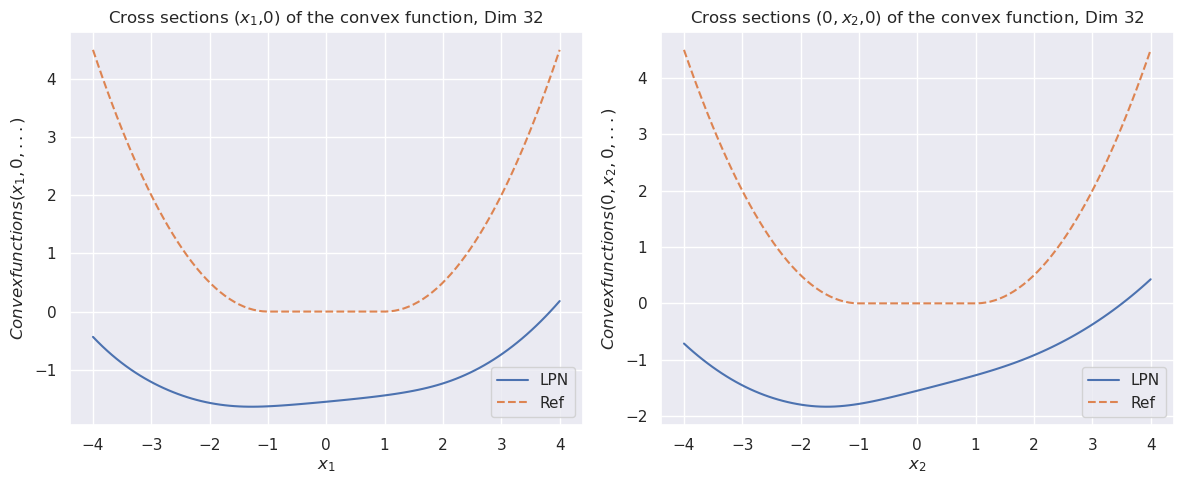

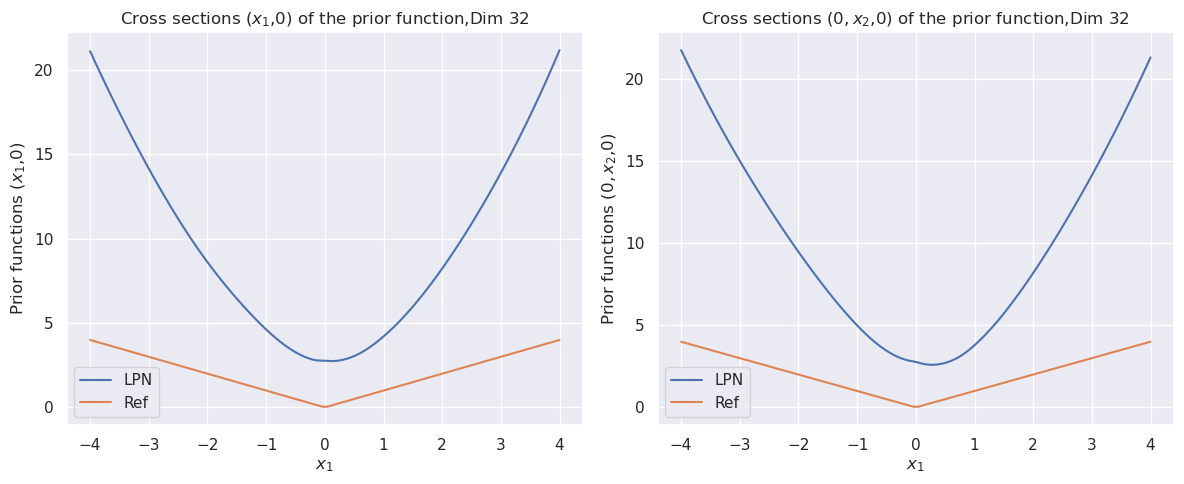

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 3632.400634765625
iteration 0 loss 1596.6217041015625


iteration 5000 loss 0.615523099899292


iteration 10000 loss 0.3655245900154114


iteration 15000 loss 0.2731964588165283


iteration 20000 loss 0.23227716982364655


iteration 25000 loss 0.19907255470752716


iteration 30000 loss 0.17480573058128357


iteration 35000 loss 0.1453791856765747


iteration 40000 loss 0.12190325558185577


iteration 45000 loss 0.10860185325145721


iteration 50000 loss 0.096646748483181


iteration 55000 loss 0.08757895976305008


iteration 60000 loss 0.07969086617231369


iteration 65000 loss 0.07400748133659363


iteration 70000 loss 0.06692071259021759


iteration 75000 loss 0.06240520626306534


iteration 80000 loss 0.05959974229335785


iteration 85000 loss 0.05692989379167557


iteration 90000 loss 0.053782690316438675


iteration 95000 loss 0.050417982041835785


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.04888392984867096


iteration 105000 loss 0.04635125771164894


iteration 110000 loss 0.043434012681245804


iteration 115000 loss 0.04106055200099945


iteration 120000 loss 0.038884084671735764


iteration 125000 loss 0.03693873807787895


iteration 130000 loss 0.03534610942006111


iteration 135000 loss 0.03393876925110817


iteration 140000 loss 0.032533932477235794


iteration 145000 loss 0.031242333352565765


iteration 150000 loss 0.030217183753848076


iteration 155000 loss 0.029123516753315926


iteration 160000 loss 0.028070813044905663


iteration 165000 loss 0.027262797579169273


iteration 170000 loss 0.026379484683275223


iteration 175000 loss 0.02552901580929756


iteration 180000 loss 0.02480631321668625


iteration 185000 loss 0.02409057319164276


iteration 190000 loss 0.023383593186736107


iteration 195000 loss 0.022781331092119217


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.022141611203551292


iteration 205000 loss 0.021913090720772743


iteration 210000 loss 0.021282071247696877


iteration 215000 loss 0.02072780579328537


iteration 220000 loss 0.02021201141178608


iteration 225000 loss 0.019653430208563805


iteration 230000 loss 0.019229350611567497


iteration 235000 loss 0.01873546652495861


iteration 240000 loss 0.01833943836390972


iteration 245000 loss 0.01790294237434864


iteration 250000 loss 0.01754564605653286


iteration 255000 loss 0.02148878201842308


iteration 260000 loss 0.016774559393525124


iteration 265000 loss 0.016378672793507576


iteration 270000 loss 0.01602955535054207


iteration 275000 loss 0.01573004759848118


iteration 280000 loss 0.015372568741440773


iteration 285000 loss 0.015122313983738422


iteration 290000 loss 0.014845079742372036


iteration 295000 loss 0.014556710608303547


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.01431124098598957


iteration 305000 loss 0.014187435619533062


iteration 310000 loss 0.013797823339700699


iteration 315000 loss 0.013427971862256527


iteration 320000 loss 0.013081202283501625


iteration 325000 loss 0.012748893350362778


iteration 330000 loss 0.01243672613054514


iteration 335000 loss 0.012151011265814304


iteration 340000 loss 0.011866001412272453


iteration 345000 loss 0.011586354114115238


iteration 350000 loss 0.011317146010696888


iteration 355000 loss 0.011065419763326645


iteration 360000 loss 0.010827272199094296


iteration 365000 loss 0.01059110090136528


iteration 370000 loss 0.010365992784500122


iteration 375000 loss 0.010155796073377132


iteration 380000 loss 0.009949897415935993


iteration 385000 loss 0.00975873228162527


iteration 390000 loss 0.009578446857631207


iteration 395000 loss 0.009405636228621006


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.009236574172973633


iteration 405000 loss 0.009200050495564938


iteration 410000 loss 0.009152167476713657


iteration 415000 loss 0.0091060446575284


iteration 420000 loss 0.009061171673238277


iteration 425000 loss 0.00901729054749012


iteration 430000 loss 0.008974257856607437


iteration 435000 loss 0.008931970223784447


iteration 440000 loss 0.008890360593795776


iteration 445000 loss 0.008849356323480606


iteration 450000 loss 0.008808922953903675


iteration 455000 loss 0.008769067004323006


iteration 460000 loss 0.00872975867241621


iteration 465000 loss 0.008690917864441872


iteration 470000 loss 0.008652531541883945


iteration 475000 loss 0.008614582009613514


iteration 480000 loss 0.008577053435146809


iteration 485000 loss 0.00853993371129036


iteration 490000 loss 0.008503252640366554


iteration 495000 loss 0.008466983214020729


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


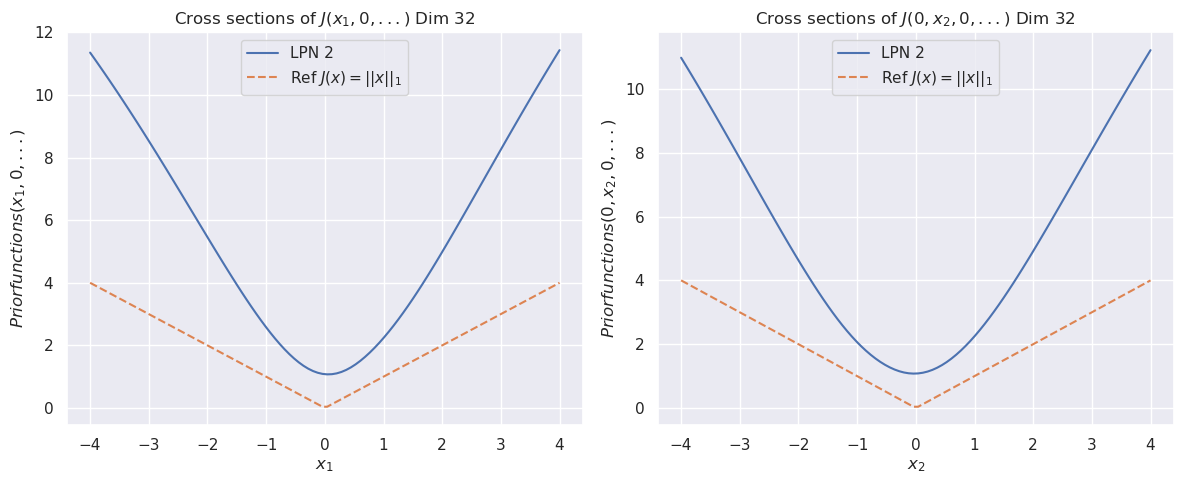

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)